# Cleaning simulated data and building ML model with exportable artifacts using CatalystML and TensorFlow

### Importing modules

In [1]:
%matplotlib inline

import cmlmaker as cml

import pandas as pd
import numpy as np

import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
import datetime as dt

## Preprocessing and creating CML artifact

### Reading in data

<p>Creating a common timestamp to use to label files throughout.</p>

In [2]:
d=dt.datetime.now()
dint=int(round(dt.datetime.timestamp(d)))

<p>Getting simulated data and inspecting properties.  Notice the catagorical, continous, and integer columns.</p>

In [3]:
filename="fin_sim_dat.csv"
df=pd.read_csv(filename)

In [4]:
df.head()

,Age,Amount,bank,cardType,entry_type,gender,transaction,v1,v2,v3,v4,fraud
0,58,20.00,Bank1,Master,chip,m,POS,1.371536,-0.588411,0.035201,-1.012560,0
1,38,0.77,Bank0,Master_Debit,chip,m,ATM,-1.278029,1.197070,1.017657,-1.650088,0
2,37,54.95,Bank5,Master_Debit,INTERNET,m,INTERNET,1.893795,-0.656074,-0.313874,0.279933,0
3,58,47.98,Bank1,Visa,chip,f,POS,2.099674,-0.872007,-0.754920,-0.599392,0
4,35,3.74,Bank10,Master,chip,f,ATM,0.400764,1.845057,-2.067862,1.757743,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
Age            10000 non-null int64
Amount         10000 non-null float64
bank           10000 non-null object
cardType       10000 non-null object
entry_type     10000 non-null object
gender         10000 non-null object
transaction    10000 non-null object
v1             10000 non-null float64
v2             10000 non-null float64
v3             10000 non-null float64
v4             10000 non-null float64
fraud          10000 non-null int64
dtypes: float64(5), int64(2), object(5)
memory usage: 937.6+ KB


In [6]:
df.describe()

,Age,Amount,v1,v2,v3,v4,fraud
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,48.244800,195.033439,-0.480903,0.370074,-0.722753,0.454489,0.100000
std,17.983476,873.382584,3.251747,2.370641,3.489661,2.142095,0.300015
min,18.000000,0.000000,-30.552380,-28.097433,-31.103685,-5.560118,0.000000
25%,33.000000,7.400000,-1.108574,-0.548831,-1.252131,-0.770973,0.000000
50%,48.000000,23.375000,-0.124252,0.154989,0.004011,0.141740,0.000000
75%,64.000000,90.965000,1.263215,0.987964,0.915464,1.096716,0.000000
max,79.000000,18096.800000,2.411499,22.057729,3.971381,12.114672,1.000000


### Initializing CML structure

<p>Creating a new instance of the structure object from the CML library, with a Name, Description, and Version.  I then change the date from the default/current date.</p>

In [7]:
cs=cml.structure("FinancialStructure","Cleaning some financial data",version='1.0.1')
cs.updateCreatedDate(dt.datetime(2020,1,1).strftime("%Y%m%d"))
print(cs)

{
    "name": "FinancialStructure",
    "description": "Cleaning some financial data",
    "version": "1.0.1",
    "createdDate": "20200101",
    "input": [],
    "structure": [],
    "output": null
}


<p>We then need to define the data type and label for the data that is going to be coming into CML for processing.  In this case a dataframe which is represented as a map datatype in CML.</p>

In [8]:
typ="array";label="inputs"
cs=cs.addInput(cml.inobj(typ,label))
print(cs)

{
    "name": "FinancialStructure",
    "description": "Cleaning some financial data",
    "version": "1.0.1",
    "createdDate": "20200101",
    "input": [
        {
            "type": "array",
            "label": "inputs"
        }
    ],
    "structure": [],
    "output": null
}


### Cleaning data and adding operations to CML

<p>It is worth noting that the inputs for the model training are different from the application.  Therefore we are adding an additional step to level the two processes.  In production the data will be coming in as an array or maps/data frames, while the training data is coming out in bulk from a data store.  Therefore we will use the concatMap operation to join all the possible maps together into one dataframe.</p>

In [ ]:
cs=cs.addOp(
    cml.concatMap(
        cml.concatMap.inputs(data="$inputs"),
        output="datatemp"
    )
)

<p>Next we take  our first step in cleaning the data.  Here we normalize the Age column between 18 and 100 and the Amount column by mean+std.  First we do this using the map command in pandas.  Following that we search for the normalize operation in CML by using the python help command on the cml package and follow it by using help on cml.normalize to get the need inputs.  We then add the two normalize operations to the CML structure.</p>

In [9]:
agemin=18;agemax=100
amountscale=df.describe().loc['mean','Amount']+df.describe().loc['std','Amount']
print(amountscale)

df.Age=df.Age.map(lambda x: (x-agemin)/(agemax-agemin))
df.Amount=df.Amount.map(lambda x: (x/amountscale))

1068.416023108812


<p>Now to add the normalization steps for Age and Amount to the CML structure.  One of the ways to discover operations in CML maker is to use the python help command on the cml object.  Then we can use the help command on cml.normalize to determine what inputs we need to include.</p>

In [38]:
help(cml.ops)

Help on class ops in module cmlmaker:

class ops(builtins.object)
 |  Methods defined here:
 |  
 |  listAllOps()
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  cleaning = <class 'cmlmaker.ops.cleaning'>
 |      Operations that fall best under data cleaning
 |  
 |  image_processing = <class 'cmlmaker.ops.image_processing'>
 |      Image processing related operations
 |  
 |  math = <class 'cmlmaker.ops.math'>
 |      Math based operations
 |  
 |  nlp = <class 'cmlmaker.ops.nlp'>
 |      Natural Language Processing(NLP) related operations
 |  
 |  restructuring = <class 'cmlmaker.ops.restructuring'>
 |      Operations that restructure da

In [11]:
help(cml.ops.normalize)

Help on class normalize in module cmlmaker:

class normalize(operation)
 |  divide all values of array by value (i.e. x/value), if minvalue is given applies (x-minval)/(value-minvalue) where x is the data
 |  
 |  Method resolution order:
 |      normalize
 |      operation
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, inputs=None, params=None, output=None)
 |      Initialize normalize operation and define inputs, parameters, and outputs
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  inputs = <class 'cmlmaker.normalize.inputs'>
 |      inputs's possible keys:
 |              data (required)- data to get mean of
 |              value (required)- value to normalize with (if starting at 0)
 |              minval (optional)- min value to start normalize with (if not starting at 0)
 |  
 |  ----------------------------------------------------------------------
 |  Methods i

In [39]:
help(cml.normalize)

Help on class normalize in module cmlmaker:

class normalize(operation)
 |  divide all values of array by value (i.e. x/value), if minvalue is given applies (x-minval)/(value-minvalue) where x is the data
 |  
 |  Method resolution order:
 |      normalize
 |      operation
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, inputs=None, params=None, output=None)
 |      Initialize normalize operation and define inputs, parameters, and outputs
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  inputs = <class 'cmlmaker.normalize.inputs'>
 |      inputs's possible keys:
 |              data (required)- data to get mean of
 |              value (required)- value to normalize with (if starting at 0)
 |              minval (optional)- min value to start normalize with (if not starting at 0)
 |  
 |  ----------------------------------------------------------------------
 |  Methods i

In [12]:
help( cml.concatMap)

Help on class concatMap in module cmlmaker:

class concatMap(operation)
 |  takes an array of maps and combines them into one.
 |  
 |  Method resolution order:
 |      concatMap
 |      operation
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, inputs=None, params=None, output=None)
 |      Initialize concatMap operation and define inputs, parameters, and outputs
 |  
 |  ----------------------------------------------------------------------
 |  Data and other attributes defined here:
 |  
 |  inputs = <class 'cmlmaker.concatMap.inputs'>
 |      inputs's possible keys:
 |              data (required)- array of maps to be combines into one
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from operation:
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  make_map(self)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors inherited from operation:
 |

In [14]:
cs=cs.addOp(
    cml.normalize(
        cml.normalize.inputs(data="$datatemp['Age']",value=agemax,minval=agemin),
        output="datatemp['Age']"
    )
)

cs=cs.addOp(
    cml.normalize(
        cml.normalize.inputs(data="$datatemp['Amount']",value=amountscale),
        output="datatemp['Amount']"
    )
)

<p>To see the result you can print the cs object to see how we have added the input and the first two operatons.</p>

In [15]:
print(cs)

{
    "name": "FinancialStructure",
    "description": "Cleaning some financial data",
    "version": "1.0.1",
    "createdDate": "20200101",
    "input": [
        {
            "type": "array",
            "label": "inputs"
        }
    ],
    "structure": [
        {
            "operation": "concatMap",
            "input": {
                "data": "$inputs"
            },
            "output": "datatemp"
        },
        {
            "operation": "normalize",
            "input": {
                "data": "$datatemp['Age']",
                "value": 100,
                "minval": 18
            },
            "output": "datatemp['Age']"
        },
        {
            "operation": "normalize",
            "input": {
                "data": "$datatemp['Amount']",
                "value": 1068.416023108812
            },
            "output": "datatemp['Amount']"
        }
    ],
    "output": null
}


<p>We apply this to additional data cleaning operations including replaceValue, oneHotEncoding, more normalizations.</p>

In [16]:
df.gender=df.gender.map(lambda x: 1 if x=="f" else 0)

In [17]:
cs=cs.addOp(
    cml.replaceValue(
        cml.replaceValue.inputs(data="$datatemp",replaceMap={"f":1,"m":0}),
        cml.replaceValue.params(col=["gender"]),       
        output='datatemp'
    )
)

In [18]:
cols=["bank","cardType","entry_type","transaction"]

for col in cols:
    vals=df[col].unique()
    for val in vals:
        df[val]=0
        df.loc[df[col]==val,val]=1

cs=cs.addOp(
    cml.ops.cleaning.oneHotEncoding(                                                        #operation we are adding
        cml.oneHotEncoding.inputs("$datatemp"),                                                   #OHE input object being included in op
        cml.oneHotEncoding.params(inputColumns=cols,keepOrig=True), #OHE params object being included in op
        output="datatemp"                                                                         #output label for resulting data
    )
)

print(df.columns)

Index(['Age', 'Amount', 'bank', 'cardType', 'entry_type', 'gender',
       'transaction', 'v1', 'v2', 'v3', 'v4', 'fraud', 'Bank1', 'Bank0',
       'Bank5', 'Bank10', 'Bank8', 'Bank9', 'Bank4', 'Bank7', 'Bank3', 'Bank2',
       'Bank6', 'Bank11', 'Bank12', 'Bank14', 'Bank13', 'Master',
       'Master_Debit', 'Visa', 'Visa_Debit', 'AmEx', 'chip', 'INTERNET',
       'internet', 'magnetic', 'POS', 'ATM'],
      dtype='object')


In [19]:
cols2normalize=['v1','v2','v3','v4']
vmax=5;vmin=-vmax
for col in cols2normalize:
    df[col]=df[col].map(lambda x: (x-vmin)/(vmax-vmin))

for c2n in cols2normalize:
    cs=cs.addOp(
        cml.ops.math.normalize(                                                        #operation we are adding
            cml.normalize.inputs(f"$datatemp['{c2n}']",5,-5),                                                   #OHE input object being included in op
            output=f"datatemp['{c2n}']"                                                                         #output label for resulting data
        )
    )

<p>Now we use pairwise operations to create polynomial combinations of features.</p>

In [20]:
df['v3*v4']=df.apply(lambda x: x['v3']*x['v4'],axis=1)
df['v3*v4*Visa']=df.apply(lambda x: x['v3*v4']*x['Visa'],axis=1)

df['v1*v2']=df.apply(lambda x: x['v1']*x['v2'],axis=1)
df['v1*v2*Master']=df.apply(lambda x: x['v1*v2']*x['Master'],axis=1)

In [21]:
cs=cs.addOp(
    cml.ops.math.multPairWise(
        cml.multPairWise.inputs(
            matrix0="$datatemp['v3']",
            matrix1="$datatemp['v4']"
        ),
        output="datatemp['v3*v4']"
    )
)

cs=cs.addOp(
    cml.ops.math.multPairWise(
        cml.multPairWise.inputs(
            matrix0="$datatemp['v3*v4']",
            matrix1="$datatemp['Visa']"
        ),
        output="datatemp['v3*v4*Visa']"
    )
)

cs=cs.addOp(
    cml.ops.math.multPairWise(
        cml.multPairWise.inputs(
            matrix0="$datatemp['v1']",
            matrix1="$datatemp['v2']"
        ),
        output="datatemp['v1*v2']"
    )
)

cs=cs.addOp(
    cml.ops.math.multPairWise(
        cml.multPairWise.inputs(
            matrix0="$datatemp['v1*v2']",
            matrix1="$datatemp['Master']"
        ),
        output="datatemp['v1*v2*Master']"
    )
)

<p>So lots of columns where made in both the CML map variable and in the pandas df.  So here we are going to just keep the important columns.</p>

In [22]:
cols2keep=["ATM","Age","AmEx","Amount","Bank0","Bank1","Bank10","Bank2","Bank3","Bank4","Bank5","Bank6","Bank7","Bank8","Bank9","INTERNET","Master","Master_Debit","POS","Visa","Visa_Debit","chip","gender","magnetic","v1","v2","v3","v4","v1*v2*Master","v3*v4*Visa"]

dfproc=df[cols2keep+['fraud']]
cs=cs.addOp(
    cml.ops.restructuring.map2table(
        cml.map2table.inputs(
            "$datatemp",
            cols2keep
        ),
        cml.map2table.params(axis=1),
        output="datatab"
    )
)

<p>To finish up the CML structure object we just need to define the output.  As with above when we are referring to a variable defined in the CML scope we lead the variable name with a $.</p>

In [23]:
cs=cs.addOutput(cml.outobj("map","$datatab"))

<p>To display the final JSON we just have to print the final cml object:</p>

In [24]:
print(cs)

{
    "name": "FinancialStructure",
    "description": "Cleaning some financial data",
    "version": "1.0.1",
    "createdDate": "20200101",
    "input": [
        {
            "type": "array",
            "label": "inputs"
        }
    ],
    "structure": [
        {
            "operation": "concatMap",
            "input": {
                "data": "$inputs"
            },
            "output": "datatemp"
        },
        {
            "operation": "normalize",
            "input": {
                "data": "$datatemp['Age']",
                "value": 100,
                "minval": 18
            },
            "output": "datatemp['Age']"
        },
        {
            "operation": "normalize",
            "input": {
                "data": "$datatemp['Amount']",
                "value": 1068.416023108812
            },
            "output": "datatemp['Amount']"
        },
        {
            "operation": "replaceValue",
            "input": {
                "data": "$data

<p>And the export the JSON we just need to call the writeToFile method of the cml structurte.</p>

In [25]:
cs.writeToFile(f'findata_{dint}.json')

In [26]:
dfproc.values.shape

(10000, 31)

### Building a Tensorflow  model

<p>Now that we have created the CML JSON object for exporting for deployment lets use the cleaned data to create a TF1.X model that we can also export and zip together.  We have created a 15% test set with the remaing being used for training.  The training set then has 15% saved for evaluation during training.  We create a 5 layer dense NN for our model and train for 50 epochs.  This yeilds a precision of ~90% and recall of about 70%.  If the layers are increase to (32,16,4,2,1) * numinps, with the same 2 outputs the precision / recall becomes ~80% /~85% greatly increasing recall at the cost of precision.</p>

<p>Here we aren't going to go into further detail in building a model or exploring more features for accuracy.  Links concerning these topics are in the medium article.</p>

In [27]:
df=dfproc


In [28]:
cols=[col for col in df.columns if col not in ["fraud"]]
len(cols)

30

In [29]:
dftrain,dftest=train_test_split(df,test_size=0.15)

In [30]:
numinps= len(cols)
numinps

30

In [31]:
dftrain2,dfeval=train_test_split(dftrain,test_size=0.15)

In [32]:
#encodedim=28
numclasses=2
#hiddim=encodedim//2
lr=0.001 #learnrate=tf.placeholder(tf.float32, name='learningrate')
droprate=0.2 #tf.placeholder(tf.float32, name='droprate')
inputs=tf.placeholder(tf.float64, shape=(None,numinps),name="inputs")
mode=tf.placeholder(tf.string, name="mode")
labels=tf.placeholder(tf.int32,shape=(None),name='labels')

dense0 = tf.layers.dense(inputs=inputs, units=numinps*8, activation=tf.nn.relu)
dropout0 = tf.layers.dropout(inputs=dense0, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense1 = tf.layers.dense(inputs=dropout0, units=numinps*4, activation=tf.nn.relu)
dropout1 = tf.layers.dropout(inputs=dense1, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense1a = tf.layers.dense(inputs=dropout1, units=numinps*3, activation=tf.nn.relu,name="dense_9")
dropout1a = tf.layers.dropout(inputs=dense1a, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense2 = tf.layers.dense(inputs=dropout1a, units=numinps*2, activation=tf.nn.relu,name="dense_10")
dropout2 = tf.layers.dropout(inputs=dense2, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense3 = tf.layers.dense(inputs=dropout2, units=numinps*1, activation=tf.nn.relu)
dropout3 = tf.layers.dropout(inputs=dense3, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)

dense4 = tf.layers.dense(inputs=dropout3, units=numclasses)#, activation=tf.nn.relu)
logits = tf.layers.dropout(inputs=dense4, rate=droprate, training=mode == tf.estimator.ModeKeys.TRAIN)
Yprobab=tf.nn.softmax(logits,name='Yprobab')
Yout = tf.argmax(Yprobab,1,name="Yout")

#loss=tf.losses.mean_squared_error(labels=inputs,predictions=dropout4)
#loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits,labels=labels)
loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits,labels=labels)
batchloss=tf.reduce_mean(loss)
trainstep=tf.train.AdamOptimizer(learning_rate=lr).minimize(loss)


W0302 12:55:37.750213 140735594709888 deprecation.py:323] From <ipython-input-32-a8296588bcc1>:10: dense (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dense instead.
W0302 12:55:37.757115 140735594709888 deprecation.py:506] From /anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0302 12:55:38.089705 140735594709888 deprecation.py:323] From <ipython-input-32-a8296588bcc1>:11: dropout (from tensorflow.python.layers.core) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.dropout instead.


In [33]:
init = tf.global_variables_initializer()
batchsize=100
#xbatch=dftrain2.loc[:,cols].head(10).values
evalbatch=dfeval[cols]
evallabels=dfeval["fraud"]
numepochs=50
#d=dt.datetime.now() (moved above to keep timestamp consistent)
#dint=int(round(dt.datetime.timestamp(d)))
savedir=f"./m_{dint}"
#savedir=f"./b_{dint}"

treerr=[]
everr=[]

report_it=50
eval_it=report_it*5

with tf.Session() as sess:
    
    sess.run(init)
    for epoch in range(numepochs):
        for i in range(dftrain2.shape[0]//batchsize):
            xbatch=dftrain2.iloc[i*batchsize:(i+1)*batchsize][cols].values
            lab=dftrain2.iloc[i*batchsize:(i+1)*batchsize]['fraud']
            _,ltr=sess.run([trainstep,batchloss],feed_dict={inputs:xbatch,labels:lab})#,learnrate:0.001,droprate:0.2,mode:tf.estimator.ModeKeys.TRAIN})
            if i%(eval_it//5)==0:
                l=sess.run([batchloss],feed_dict={inputs:evalbatch,labels:evallabels})#,learnrate:0.001,droprate:0.2,mode:tf.estimator.ModeKeys.EVAL})
                treerr.append(ltr)
                everr.append(l)
            
            if i%report_it==0 and i>0:
                print("train: ",epoch,i,ltr)
            if i%eval_it==0  and i>0:
                print("evalu: ",epoch,i,l[0])
    print("evalu: ",epoch,i,l[0])
    
    print("Running Test data...")
    #out=[]
    if 1:
    #for i in range(dftest.shape[0]):
        testbatch=np.array(dftest.iloc[:][cols].values)
        testlabels=np.array(dftest.iloc[:]['fraud'].values)
        print(type(testbatch))
        l,yout=sess.run([batchloss,Yout],feed_dict={inputs:testbatch,labels:testlabels})#,learnrate:0.001,droprate:0.2,mode:tf.estimator.ModeKeys.EVAL})
        #out.append()
        dfout2=pd.DataFrame(data={"label":dftest.iloc[:]['fraud'].values,"err":l,"pred":yout})
    tensor_info_x = tf.saved_model.utils.build_tensor_info(inputs)
    tensor_info_y = tf.saved_model.utils.build_tensor_info(Yout)
    prediction_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
      inputs={'inputs': tensor_info_x},
      outputs={'Yout': tensor_info_y},
      method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
      )  )
    
    builder = tf.saved_model.builder.SavedModelBuilder(savedir)
    builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
              prediction_signature 
      },
    )
    builder.save()

    
    tf.train.write_graph(sess.graph, 'model/text', f'/Users/avanderg@tibco.com/working/CatalystMLFlogoDeployDemo/train_{dint}.pbtxt')

train:  0 50 0.1507332778305331
train:  1 50 0.1364558740664814
train:  2 50 0.09133186494128534
train:  3 50 0.0815679468302182
train:  4 50 0.07736924645792835
train:  5 50 0.07700036518999094
train:  6 50 0.06920933382799474
train:  7 50 0.0596357600155721
train:  8 50 0.04853340826111051
train:  9 50 0.043059599488720395
train:  10 50 0.035156107716507644
train:  11 50 0.038983543087572375
train:  12 50 0.027604965377797906
train:  13 50 0.03314504518826392
train:  14 50 0.024926639813357573
train:  15 50 0.044613330323084614
train:  16 50 0.12752801006129721
train:  17 50 0.05942309433000601
train:  18 50 0.024666173959386386
train:  19 50 0.01619940335827466
train:  20 50 0.027750996897906013
train:  21 50 0.021290275482503312
train:  22 50 0.015911883827982594
train:  23 50 0.014853454996201765
train:  24 50 0.09509376156612032
train:  25 50 0.02945596582974164
train:  26 50 0.03816609124551412
train:  27 50 0.0424339510632393
train:  28 50 0.07059948067293587
train:  29 50 0.01

W0302 12:56:04.210981 140735594709888 deprecation.py:323] From <ipython-input-33-f208be853db0>:47: build_tensor_info (from tensorflow.python.saved_model.utils_impl) is deprecated and will be removed in a future version.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.


train:  49 50 0.020340666584497673
evalu:  49 71 0.281221836770226
Running Test data...
<class 'numpy.ndarray'>


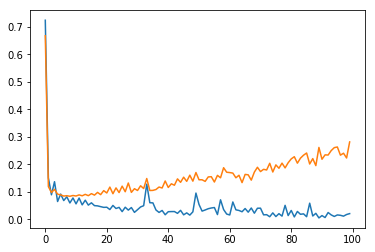

In [34]:
plt.plot(treerr)
plt.plot(everr)
plt.show()


In [35]:
def prec_recall(df):
    '''Assumes columns of pred and label'''
    tp=df[(df['label']==1)&(df['pred']==1)].shape[0]#number of true positives
    recall = tp/df['label'].sum()                   #recall
    prec =   tp/df['pred'].sum()                    #precision
    fp=df[(df['label']!=1)&(df['pred']==1)].shape[0]#number of false positives
    fpr=fp/df['pred'].sum()                         #False positive rate
    return prec,recall,fpr

prec2,recall2,fpr2=prec_recall(dfout2)
print("DNNClassifier prec {:5.3f}, recall {:5.3f}, fpr {:5.3f}".format(prec2,recall2,fpr2))


DNNClassifier prec 0.800, recall 0.851, fpr 0.200


<p>Zipping up the model files into a single Archive, that can be directly loaded into Flogo.</p>

In [36]:
s=f"cd {savedir}; zip -r Archive_{dint}.zip sav* var*; mv Arch* ../.; cd .."
os.system(s)
stream = os.popen(s)
output = stream.read()
outlines=output.strip().rsplit("\n")
for line in outlines:
    print(line.strip())

adding: saved_model.pb (deflated 88%)
adding: variables/ (stored 0%)
adding: variables/variables.data-00000-of-00001 (deflated 4%)
adding: variables/variables.index (deflated 43%)
